In [128]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.special import expit, logit
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, median_absolute_error
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import scale

np.random.seed(1)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

# Prepare the data

In [150]:
# load
df = pd.read_pickle('../data/process/schools2017.pkl')

# select columns
df = df[[
    'Charter School?',
    'Percent Asian',
    'Percent Black',
    'Percent Hispanic',
    'Percent Other',
    'Percent English Language Learners',
    'Percent Students with Disabilities',
    'Economic Need Index',
    
    'Mean Scale Score - ELA',
    '% Level 2 - ELA',
    '% Level 3 - ELA',
    '% Level 4 - ELA',
    'Mean Scale Score - Math',
    '% Level 2 - Math',
    '% Level 3 - Math',
    '% Level 4 - Math',
    
    '# Students in HS Admissions',
    '# SHSAT Testers',
    '% SHSAT Testers',
]].copy()
print(df.shape[0], "schools")

# drop schools with missing test data
df = df[df.loc[:, 'Mean Scale Score - ELA':'% Level 4 - Math'].notnull().all(axis=1)]
print(df.shape[0], "schools after dropping missing test data")

# schools with 0-5 SHSAT testers have this value set to NaN
applicantsok = df['# SHSAT Testers'].notnull()

# convert percentages to the (0, 1) range
bad_pct_c = [
    '% Level 2 - ELA',
    '% Level 3 - ELA',
    '% Level 4 - ELA',
    '% Level 2 - Math',
    '% Level 3 - Math',
    '% Level 4 - Math',
]
df.loc[:, bad_pct_c] = df.loc[:, bad_pct_c] / 100.0

# standardize score columns (ease of interpretation + algorithm stability)
score_c = ['Mean Scale Score - ELA', 'Mean Scale Score - Math']
df.loc[:, score_c] = df.loc[:, score_c].apply(scale)

594 schools
588 schools after dropping missing test data


# Create models

In [151]:
# data
in_columns = [
    'Charter School?',
    'Percent Asian',
    'Percent Black',
    'Percent Hispanic',
    'Percent Other',
    'Percent English Language Learners',
    'Percent Students with Disabilities',
    'Economic Need Index',
    
    'Mean Scale Score - ELA',
    '% Level 2 - ELA',
    '% Level 3 - ELA',
    '% Level 4 - ELA',
    'Mean Scale Score - Math',
    '% Level 2 - Math',
    '% Level 3 - Math',
    '% Level 4 - Math', 
]
inputs = df[applicantsok][in_columns]
outputs = logit(df[applicantsok]['% SHSAT Testers'])

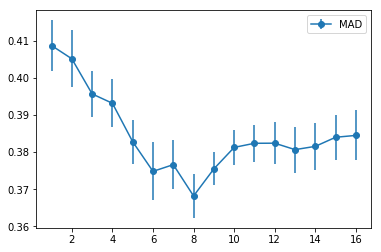

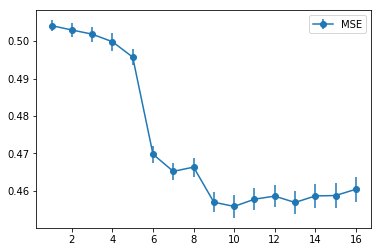

In [157]:
# cross-validation (pure PCA)

cv_results = []
n_splits = 10
n_repeats = 20
for n_components in range(1, inputs.shape[1] + 1):
    mad_scores = []
    mse_scores = []
    
    x = PCA(n_components).fit_transform(inputs)
    x = pd.DataFrame(x, index=inputs.index, columns=["PC{}".format(i) for i in range(1, n_components + 1)])
    x['Constant'] = 1
    y = outputs.copy()
    

    cv = RepeatedKFold(n_splits, n_repeats, random_state=1)    
    for train, test in cv.split(x):
        x_train = x.iloc[train]
        x_test = x.iloc[test]
        y_train = y.iloc[train]
        y_test = y.iloc[test]
        
        model = sm.RLM(y_train, x_train, M=sm.robust.norms.HuberT())
        results = model.fit()
        predictions = model.predict(results.params, exog=x_test)
        mad = median_absolute_error(y_test, predictions)
        mse = mean_squared_error(y_test, predictions)
        mad_scores.append(mad)
        mse_scores.append(mse)
        
    mad_scores = np.array(mad_scores).reshape(n_repeats, n_splits).mean(axis=1)  # mean of each repeat
    mse_scores = np.array(mse_scores).reshape(n_repeats, n_splits).mean(axis=1)  # mean of each repeat
        
    mad_mean = np.mean(mad_scores)
    mad_std = np.std(mad_scores)
    mse_mean = np.mean(mse_scores)
    mse_std = np.std(mse_scores)
    
    cv_result = (n_components, mad_mean, mse_mean, mad_std, mse_std)
    cv_results.append(cv_result)
    
df_columns = ['n_components', 'mad__mean', 'mse__mean', 'mad__std', 'mse__std']
cv_results_df = pd.DataFrame(cv_results, columns=df_columns)
cvdf = cv_results_df

In [ ]:
plt.figure()
plt.errorbar(cvdf.n_components, cvdf.mad__mean, cvdf.mad__std, marker='o', label='MAD')
plt.legend()

plt.figure()
plt.errorbar(cvdf.n_components, cvdf.mse__mean, cvdf.mse__std, marker='o', label='MSE')
plt.legend()

The sweet spot for robustness seems to be 8 PC.